<a href="https://colab.research.google.com/github/dcheney01/DeepLearning/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import glob
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

import matplotlib.pyplot as plt # this is so that you can see which functions come from the pyplot library
rcParams = plt.rcParams
plt.rcParams['figure.figsize'] = [20,20]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])
    
from google.colab import files

In [46]:
def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

In [47]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
     
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [48]:
def gram_matrix(input):
  # input will be a list of features of the output from the model.
  # Shape should return batch, channel, width, height 
  _, a, b, c = input.shape
  return input.view(a, b*c).mm(input.view(a, b*c).t())

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
class ContentLoss(nn.Module):
  def __init__(self):
    super(ContentLoss, self).__init__()

  def forward(self, input, target):
    return F.mse_loss(input, target)


# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
class StyleLoss(nn.Module):
  def __init__(self):
    super(StyleLoss, self).__init__()

  def forward(self, input, target):
    return F.mse_loss(gram_matrix(input),gram_matrix(target))

In [102]:
# Use this code to upload images
content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))

# # After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
style_image_orig = Image.open(style_path)

# Load and normalize the images
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512,512)),
    transforms.ToTensor(),
])

content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

Upload Content Image


Saving content.jfif to content.jfif

Upload Style Image


Saving style.jpg to style (6).jpg
Content Path: <_io.BytesIO object at 0x7ff916537050>
Style Path: <_io.BytesIO object at 0x7ff9177710b0>


In [108]:
# initialize generated_image
generated_image = content_image.clone().requires_grad_(True)

# optimizer and objectives
optimizer = optim.Adam([generated_image], 0.1)

#initialize the models
content_model = VGGIntermediate(requested=[14, 21]).eval().requires_grad_(False).cuda()
style_model = VGGIntermediate(requested=[0, 5, 10, 17, 24]).eval().requires_grad_(False).cuda()
model = VGGIntermediate(requested=[0, 5, 10, 14, 17, 21, 24]).eval().requires_grad_(False).cuda()

# Hyperparameters
num_epochs = 600
alpha = 1
beta = 1000

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
content_objective = ContentLoss()
style_objective = StyleLoss()

epoch_progress = tqdm(total=num_epochs, position=0, leave=False)

for epoch in range(num_epochs):
  epoch_progress.set_description('epoch:{}'.format(epoch))
          
  content_features = content_model(content_image)
  style_features = style_model(style_image)
  gen_features = model(generated_image)

  style_loss = content_loss = 0

  for layer, layer_output in content_features.items():
    content_loss += content_objective(gen_features[layer], layer_output)

  # only do for style/gen
  for layer, layer_output in style_features.items():
    style_loss += style_objective(gen_features[layer], layer_output)

  total_loss = alpha*content_loss + beta*style_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # if (epoch+1) % 50 == 0:
  #   print('Content Loss: {}'.format(content_loss.item()))
  #   print('Style Loss: {}'.format(style_loss.item()))
  #   print('Total Loss: {}'.format(total_loss.item()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
epoch:599:   0%|          | 0/600 [01:23<?, ?it/s]

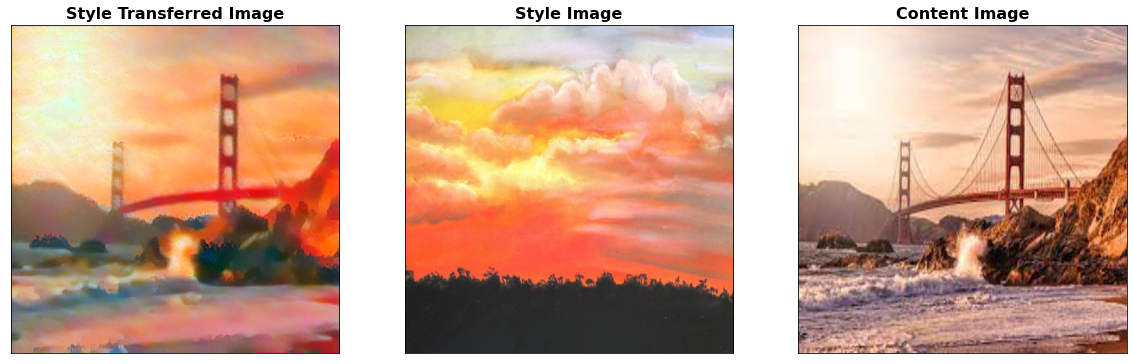

In [109]:
plt.subplot(131)
plt.imshow(np.transpose(generated_image.clamp(0,1).squeeze(0).cpu().detach().numpy(), (1,2,0)))
just_title("Style Transferred Image")

plt.subplot(132)
plt.imshow(np.transpose(style_image.squeeze(0).cpu().detach().numpy(), (1,2,0)))
just_title("Style Image")

plt.subplot(133)
plt.imshow(np.transpose(content_image.squeeze(0).cpu().detach().numpy(), (1,2,0)))
just_title("Content Image")